# Import Dataset
Upload the dataset csv file "health_sensed_variables_dataset.csv" to the Colab instance.

The Dataset can be found attached to [this issue](https://github.com/marcoom/health-sensor-simulator/issues/2)

In [6]:
import pandas as pd

df = pd.read_csv("health_sensed_variables_dataset.csv")

In [7]:
df.head()

,hearth_rate,oxygen_saturation,breathing_rate,blood_pressure_systolic,blood_presure_diastolic,body_temperature,is_outlier
0,80.842392,97.891526,16.420673,99.471810,70.580017,36.642781,1
1,79.114897,96.430763,17.464405,114.573197,68.629673,36.840147,1
2,84.290832,96.608935,16.178116,96.799187,69.259621,36.629311,1
3,80.702831,97.137639,16.749402,112.494754,72.717150,36.372384,1
4,76.411015,98.843859,16.325635,110.327587,71.813878,36.870559,1


# Train Test Split
We are going to perform a 80/20 split between train and test

In [8]:
from sklearn.model_selection import train_test_split

X=df.drop(columns=["is_outlier"])
y=df["is_outlier"]

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [9]:
# Separate inliers from outliers
df_inliers = df[df["is_outlier"] == 1]
df_outliers = df[df["is_outlier"] == -1]

x_train_inliers, x_test_inliers = train_test_split(df_inliers.drop(columns=["is_outlier"]), test_size=0.2)

# Isolation Forest (IF)
This is a widely adopted model for anomaly detection

## Model with default parameters
To get a base model that we can use as a reference point for further fine tuning

In [10]:
from sklearn.ensemble import IsolationForest
import numpy as np

In [11]:
# Define model
clf = IsolationForest(
    n_estimators=100, # number of base estimators in the ensemble
    max_samples='auto', # number of samples to draw from X to train each base estimator. Can be float 0-1
    contamination='auto', # proportion of outliers in the data set
    max_features=1.0, # number of features to draw from X to train each base estimator. Can be float 0-1
    random_state=42)

# Fit model
clf.fit(x_train)

# Predict
y_pred = clf.predict(x_test) # Predict

In [12]:
# Evaluate model
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def evaluate_model(y_true, y_pred):
  labels = [-1, 1]  # Fixed order: outlier, inlier
  cm = confusion_matrix(y_true, y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Outlier (-1)", "Inlier (1)"])
  cm_display.plot()
  plt.show()
  clf_report = classification_report(y_true, y_pred, output_dict=False)
  print(classification_report(y_true, y_pred, labels=labels,
                                target_names=["Outlier", "Inlier"]))
  return clf_report

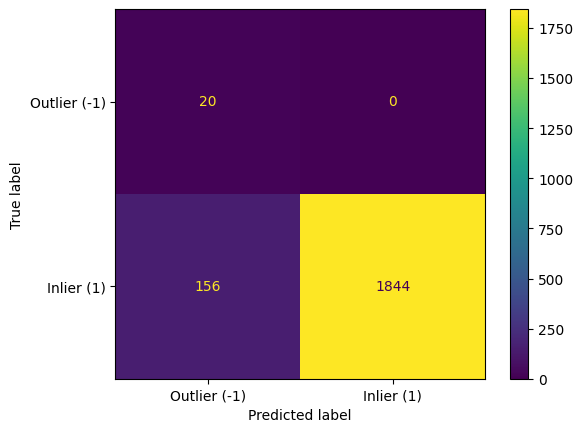

              precision    recall  f1-score   support

     Outlier       0.11      1.00      0.20        20
      Inlier       1.00      0.92      0.96      2000

    accuracy                           0.92      2020
   macro avg       0.56      0.96      0.58      2020
weighted avg       0.99      0.92      0.95      2020



In [13]:
clf_report = evaluate_model(y_test, y_pred)

Given that a False Negative (FN) is costly (is an outlier, but undetected), then we are going to optimize **Recall** = TP/(TP+FN)

## Hyperparameter Tuning

In [14]:
# Calculate contamination
num_outliers = y_train[y_train==-1].count()
dataset_size = y_train.count()
contamination = num_outliers/dataset_size

print(f"Contamination: {contamination}")

Contamination: 0.009900990099009901


In [15]:
import numpy as np
import pandas as pd
from itertools import product
from math import prod
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

grid = {
    "n_estimators":  [10, 100, 1000],
    "max_samples":   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "contamination": [contamination],
    "max_features":  [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
best = {"recall": -1, "f1": -1, "precision": -1, "estimator": None, "params": None}

total = prod(len(v) for v in grid.values())

for i, (ne, ms, cont, mf) in enumerate(product(grid["n_estimators"], grid["max_samples"], grid["contamination"], grid["max_features"]), start=1):
    print(f"Training model {i}/{total} ({i/total:.0%})", flush=True)

    clf = IsolationForest(
        n_estimators=ne,
        max_samples=ms,
        contamination=cont,
        max_features=mf,
        random_state=42
    ).fit(x_train)

    y_pred = clf.predict(x_test)

    precision = precision_score(y_test, y_pred, pos_label=True, zero_division=0)
    recall    = recall_score(y_test, y_pred,    pos_label=True, zero_division=0)
    f1        = f1_score(y_test, y_pred,        pos_label=True, zero_division=0)
    support   = int(np.sum(y_test))

    row = {
        "n_estimators": ne,
        "max_samples": ms,
        "contamination": cont,
        "max_features": mf,
        "precision_outlier": precision,
        "recall_outlier": recall,
        "f1_outlier": f1,
        "support_outlier": support,
    }
    results.append(row)

    is_better = (
        (recall > best["recall"]) or
        (recall == best["recall"] and f1 > best["f1"]) or
        (recall == best["recall"] and f1 == best["f1"] and precision > best["precision"])
    )
    if is_better:
        best.update({"recall": recall, "f1": f1, "precision": precision, "estimator": clf, "params": row})

results_df = pd.DataFrame(results).sort_values(
    by=["recall_outlier", "f1_outlier", "precision_outlier"], ascending=False
).reset_index(drop=True)

best_estimator = best["estimator"]
best_params = {k: best["params"][k] for k in ["n_estimators", "max_samples", "contamination", "max_features"]}

print("Best (by recall) params:", best_params)
print(results_df.head(10))


Training model 1/144 (1%)
Training model 2/144 (1%)
Training model 3/144 (2%)
Training model 4/144 (3%)
Training model 5/144 (3%)
Training model 6/144 (4%)
Training model 7/144 (5%)
Training model 8/144 (6%)
Training model 9/144 (6%)
Training model 10/144 (7%)
Training model 11/144 (8%)
Training model 12/144 (8%)
Training model 13/144 (9%)
Training model 14/144 (10%)
Training model 15/144 (10%)
Training model 16/144 (11%)
Training model 17/144 (12%)
Training model 18/144 (12%)
Training model 19/144 (13%)
Training model 20/144 (14%)
Training model 21/144 (15%)
Training model 22/144 (15%)
Training model 23/144 (16%)
Training model 24/144 (17%)
Training model 25/144 (17%)
Training model 26/144 (18%)
Training model 27/144 (19%)
Training model 28/144 (19%)
Training model 29/144 (20%)
Training model 30/144 (21%)
Training model 31/144 (22%)
Training model 32/144 (22%)
Training model 33/144 (23%)
Training model 34/144 (24%)
Training model 35/144 (24%)
Training model 36/144 (25%)
Training model

Visualize the parameters grid in an interactive plot

In [16]:
import numpy as np
import plotly.graph_objects as go

dfv = results_df.copy()
dfv["x_log_ne"] = np.log10(dfv["n_estimators"])
tick_vals = np.log10(sorted(dfv["n_estimators"].unique()))
tick_text = [str(v) for v in sorted(dfv["n_estimators"].unique())]

sizes = 6 + 10 * dfv["f1_outlier"].clip(lower=0)

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=dfv["x_log_ne"],
    y=dfv["max_samples"],
    z=dfv["max_features"],
    mode="markers",
    name="Models",
    marker=dict(
        size=sizes,
        color=dfv["f1_outlier"],
        colorscale="Turbo",
        colorbar=dict(title="F1"),
        opacity=0.9
    ),
    text=[
        f"n_estimators={ne}<br>"
        f"max_samples={ms:.2f}<br>"
        f"max_features={mf:.2f}<br>"
        f"F1={f1:.3f} · Recall={rc:.3f} · Precision={pr:.3f}"
        for ne, ms, mf, f1, rc, pr in zip(
            dfv["n_estimators"], dfv["max_samples"], dfv["max_features"],
            dfv["f1_outlier"], dfv["recall_outlier"], dfv["precision_outlier"]
        )
    ],
    hovertemplate="%{text}<extra></extra>"
))

best_idx = dfv["f1_outlier"].idxmax()
fig.add_trace(go.Scatter3d(
    x=[dfv.loc[best_idx, "x_log_ne"]],
    y=[dfv.loc[best_idx, "max_samples"]],
    z=[dfv.loc[best_idx, "max_features"]],
    mode="markers",
    name="Best F1",
    marker=dict(size=14, color="black", symbol="diamond", line=dict(width=2, color="white")),
    hovertemplate="Best F1<br>%{x}, %{y}, %{z}<extra></extra>"
))

fig.update_layout(
    title="Isolation Forest grid — F1 score",
    scene=dict(
        xaxis=dict(title="n_estimators (log10)", tickvals=tick_vals, ticktext=tick_text),
        yaxis=dict(title="max_samples"),
        zaxis=dict(title="max_features")
    ),
    legend=dict(x=0.02, y=0.98),
    margin=dict(l=10, r=10, b=10, t=40)
)

fig.show()


From the Interactive plot above we can conclude:
- n_estimators: 10 is too low. Between 100 and 1000 there is not much difference in metrics and performance, so we will choose **n_estimators=1000** as the inference may be slightly better, because there are more trees, and performance is not too diminished
- max_samples: between 0.4 and 1, there is not much difference. We will choose **max_samples=0.7**
- max_features: between 0.6 and 1, there is not much difference. We will choose **max_features=0.8**

## Final Model

### Train and Evaluate

In [17]:
print(f"Contamination: {contamination}")

Contamination: 0.009900990099009901


In [18]:
# Define model
clf = IsolationForest(
    n_estimators=1000, # number of base estimators in the ensemble
    max_samples=0.7, # number of samples to draw from X to train each base estimator. Can be float 0-1
    contamination = contamination, # proportion of outliers in the data set
    max_features=0.8, # number of features to draw from X to train each base estimator. Can be float 0-1
    random_state=42)

# Fit model
clf.fit(x_train)

# Predict
y_pred = clf.predict(x_test) # Predict

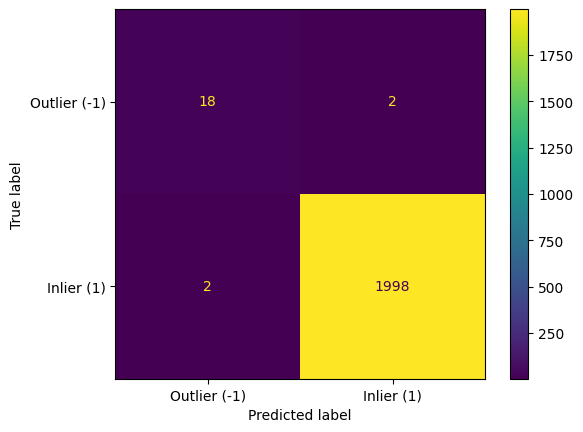

              precision    recall  f1-score   support

     Outlier       0.90      0.90      0.90        20
      Inlier       1.00      1.00      1.00      2000

    accuracy                           1.00      2020
   macro avg       0.95      0.95      0.95      2020
weighted avg       1.00      1.00      1.00      2020



In [19]:
clf_report = evaluate_model(y_test, y_pred)

### Examples

In [20]:
test_outlier = df[df["is_outlier"] == -1].sample(1).drop(columns=["is_outlier"])
test_inlier = df[df["is_outlier"] == 1].sample(1).drop(columns=["is_outlier"])
test_manual = pd.DataFrame([{
    "hearth_rate": 74.196677,
    "oxygen_saturation": 98.559586,
    "breathing_rate": 16.046316,
    "blood_pressure_systolic": 108.775277,
    "blood_presure_diastolic": 70.671704,
    "body_temperature": 36.648306,
}])

print("----- Predictions-----")
print("Outlier: ", clf.predict(test_outlier)[0], ", score: ", clf.decision_function(test_outlier)[0])
print("Inlier: ", clf.predict(test_inlier)[0], ", score: ", clf.decision_function(test_inlier)[0])
print("Manual: ", clf.predict(test_manual)[0], ", score: ", clf.decision_function(test_manual)[0])

----- Predictions-----
Outlier:  -1 , score:  -0.033711890523366095
Inlier:  1 , score:  0.16283079498888547
Manual:  1 , score:  0.16886047365619195


### Plot Decision Boundaries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.base import BaseEstimator

def plot_iforest_boundaries_all_pairs(
    clf, X, *, grid_resolution=100, eps=10,
    use_quantile_clip=False, q_low=0.01, q_high=0.99
):
    """
    clf: IsolationForest already trained on X's columns
    X: pandas.DataFrame with features used in the fit method
    """
    cols = list(X.columns)
    med = X.median().values.astype(float)
    q_low_v = X.quantile(q_low)
    q_high_v = X.quantile(q_high)

    class Estimator2D(BaseEstimator):
        def __init__(self, base_clf, fixed_vec, i, j, cols):
            self.base_clf = base_clf
            self.fixed = np.asarray(fixed_vec, dtype=float)
            self.i, self.j = i, j
            self.cols = cols
            # Mark as "fitted" for check_is_fitted:
            self.is_fitted_ = True
            self.n_features_in_ = 2

        def fit(self, X=None, y=None):
            # Does not retrain the model - only to be compatible with sklearn's interface
            return self

        def _expand_df(self, X2):
            X2 = np.asarray(X2, dtype=float)
            full = np.tile(self.fixed, (X2.shape[0], 1))
            full[:, self.i] = X2[:, 0]
            full[:, self.j] = X2[:, 1]
            return pd.DataFrame(full, columns=self.cols)

        def predict(self, X2):
            return self.base_clf.predict(self._expand_df(X2))

        def decision_function(self, X2):
            return self.base_clf.decision_function(self._expand_df(X2))

    pairs = list(combinations(range(len(cols)), 2))
    ncols = 3
    nrows = int(np.ceil(len(pairs) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    axes = axes.ravel()

    pred_all = clf.predict(X.values)         # -1=outlier, 1=inlier
    is_outlier = (pred_all == -1).astype(int)

    for ax, (i, j) in zip(axes, pairs):
        XiXj = X.iloc[:, [i, j]]
        XiXj_plot = (XiXj.clip(lower=q_low_v[[cols[i], cols[j]]].values,
                               upper=q_high_v[[cols[i], cols[j]]].values)
                     if use_quantile_clip else XiXj)

        est2d = Estimator2D(clf, med, i, j, cols)

        sc = ax.scatter(
            XiXj.values[:, 0], XiXj.values[:, 1],
            c=is_outlier, s=12, edgecolor="k", linewidths=0.2, alpha=0.2
        )

        disp = DecisionBoundaryDisplay.from_estimator(
            est2d,
            XiXj_plot.values,        # 2D grid
            response_method="predict",
            grid_resolution=grid_resolution,
            eps=eps,
            alpha=0.7,
            ax=ax,
        )

        ax.set_title(f"{cols[i]} vs {cols[j]}")
        ax.set_xlabel(cols[i]); ax.set_ylabel(cols[j])
        ax.set_aspect("equal", adjustable="datalim")
        handles, _ = sc.legend_elements()
        ax.legend(handles, ["outliers", "inliers"], title="predicted", loc="best")

    for k in range(len(pairs), len(axes)):
        fig.delaxes(axes[k])

    fig.suptitle("Binary decision boundary of IsolationForest (feature-pair slices)", fontsize=16)
    fig.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



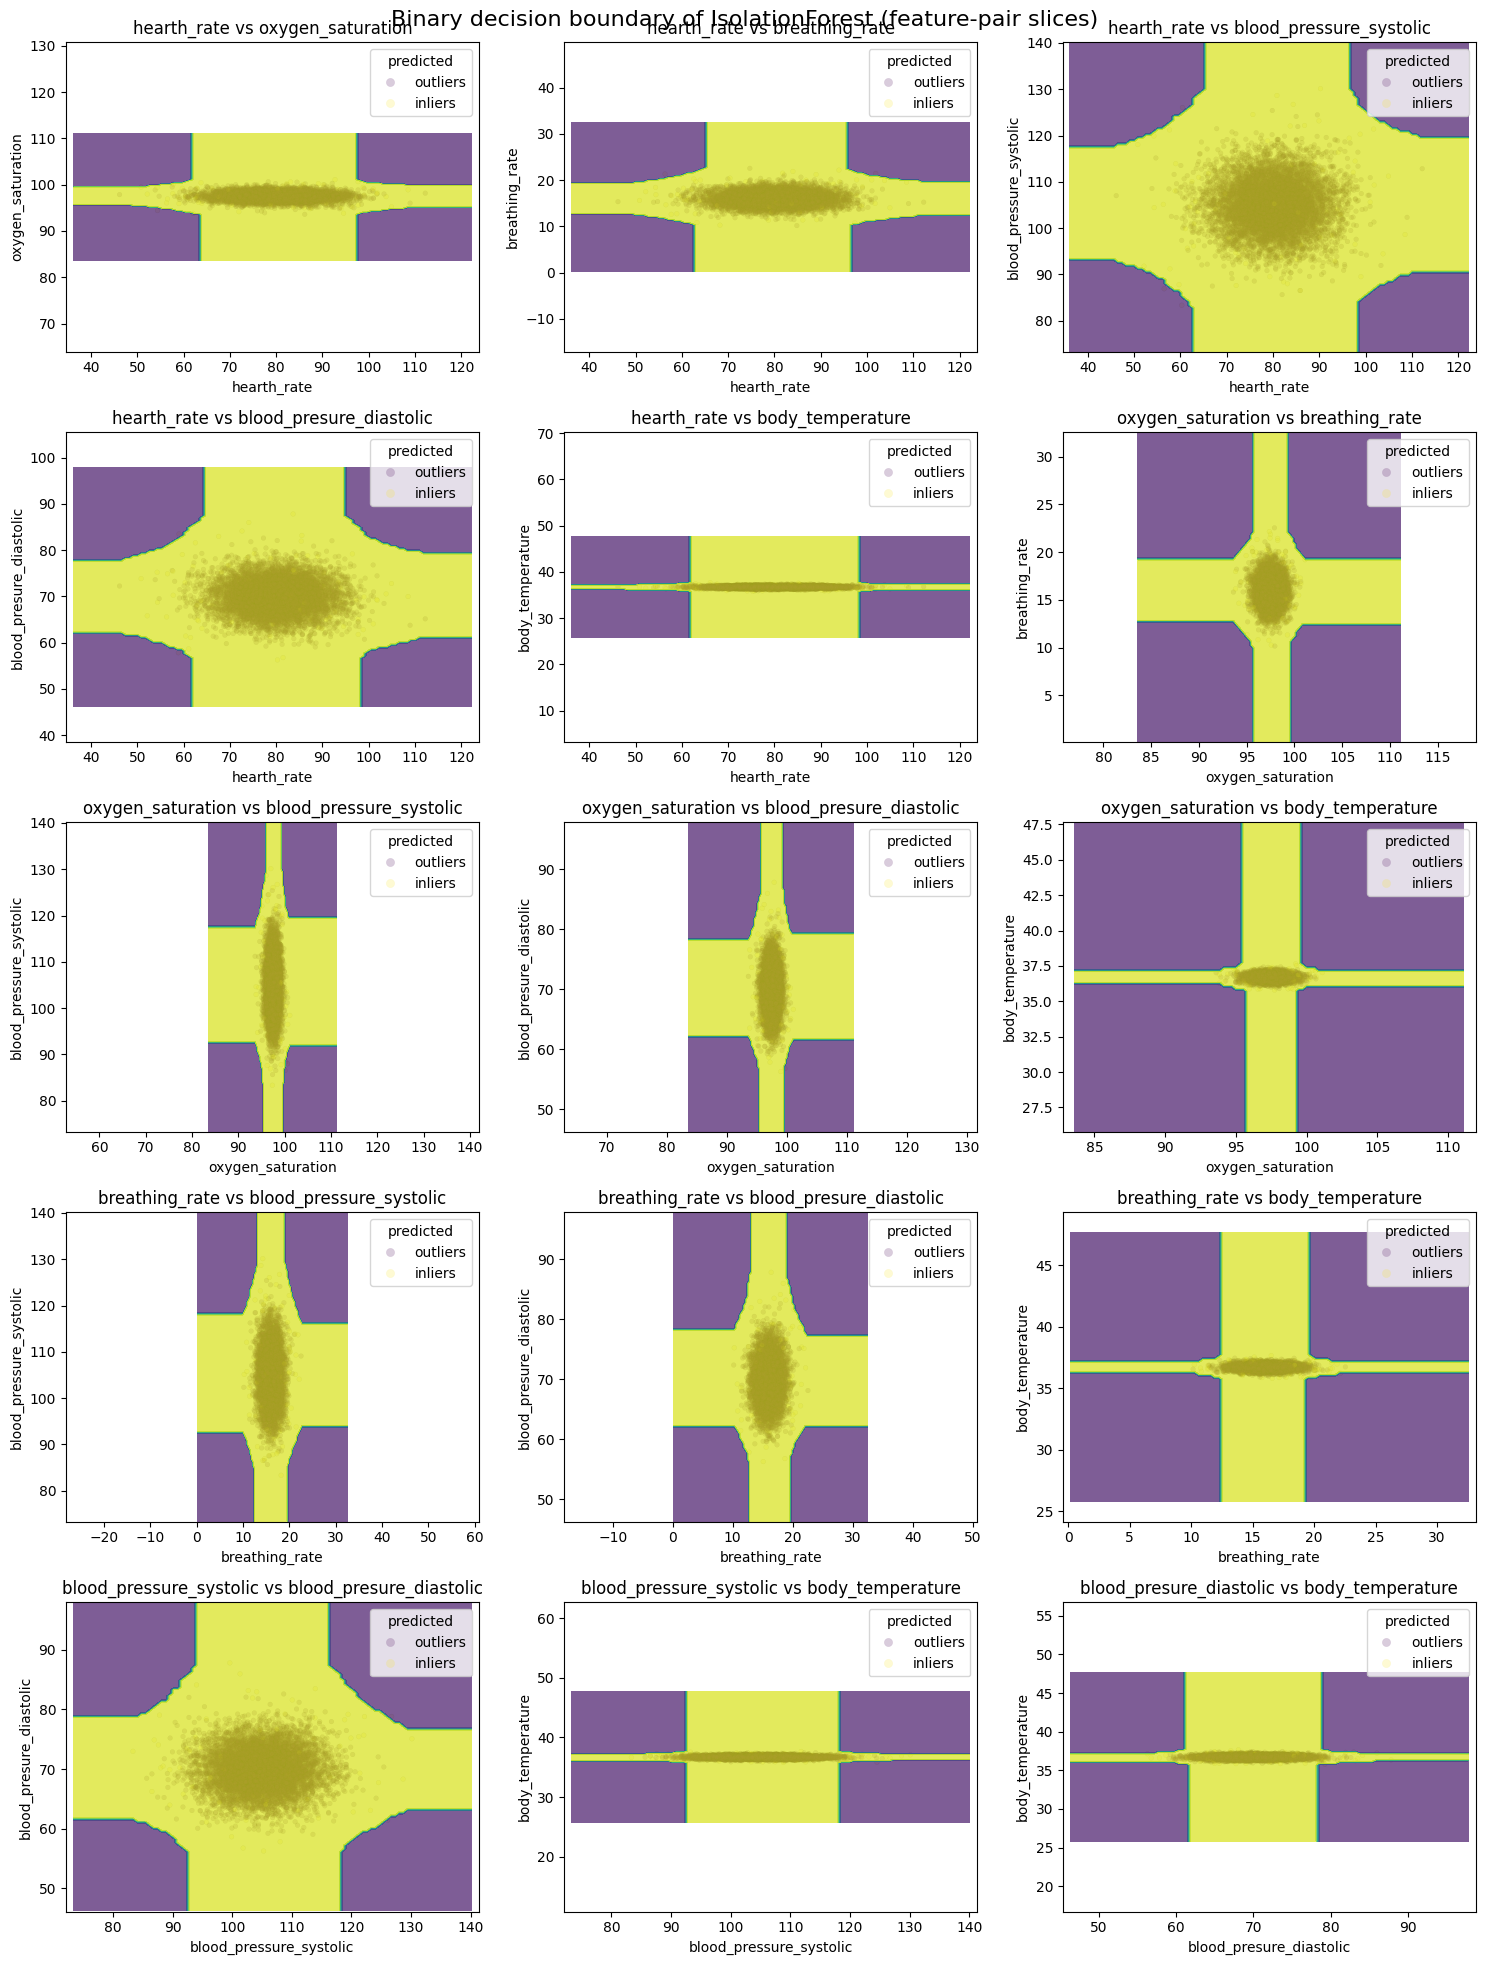

In [22]:
plot_iforest_boundaries_all_pairs(clf, x_train)

Here we can clearly see a limitation of the isolation forest algorithm. Considering that our data consists of a well defined cluster, we would expect that the decision boundary to be an ellipse that includes all inliers, but instead we get a "cross" pattern. This is because of the random cuts of each decision tree: each cut takes a random dimension and makes a split, and if a datapoint is an outlier in a single dimension, then the algorithm may take many splits to reach the dimension where the datapoint is an anomaly, and this produces that the anomalous value is classified as an inlier, because it took many splits to reach the dimension where it has an anomalous value.

A value that is an outlier in two or more variables can be easily identified, but if the datapoint has an anomalous value in a single variable, then it may be misclasified as an inlier.

A more detailed explanation can be found here: https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b/

Because of this limitation of the algorithm, **Isolation Forest is discarded** as a suitable anomaly detection algorithm for this project.

### Save and load model

**Store final model as file**

In [23]:
# Save model

from joblib import dump
import sklearn
import numpy as np

artifact = {
    "model": clf,
    "feature_names": x_train.columns.tolist(),
    "metadata": {
        "contamination": contamination,
        "sklearn_version": sklearn.__version__,
    }
}
dump(artifact, "isoforest.joblib", compress=3)


['isoforest.joblib']

**Load final model from file**

Upload the file *isoforest.joblib* before running the following

In [24]:
from joblib import load
import pandas as pd
import numpy as np

# Load artifact
artifact = load("isoforest.joblib")
clf = artifact["model"]
features = artifact["feature_names"]

In [25]:
# One-sample inference payload (your example)
X_new = pd.DataFrame([{
    "hearth_rate": 74.196677,
    "oxygen_saturation": 98.559586,
    "breathing_rate": 16.046316,
    "blood_pressure_systolic": 108.775277,
    "blood_presure_diastolic": 70.671704,
    "body_temperature": 36.648306,
}], columns=features)  # enforce feature order

# Predict (boolean: True=outlier, False=inlier)
y_pred_bool = (clf.predict(X_new) == -1)#[0]

print("Predicted is_outlier:", bool(y_pred_bool))

Predicted is_outlier: False


# Extended Isolation Forest (EIF)
EIF is a generalization of IF that addresses the limitations of axis-parallel splitting by introducing random slope hyperplanes, leading to improved anomaly detection performance, especially in complex datasets and higher dimensions.

### Train and Evaluate

In [26]:
!pip install isotree

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from isotree import IsolationForest as IsoEIF

In [34]:
# To emulate max_samples=0.7:
sample_size = int(0.7 * len(x_train))

# Pipeline: StandardScaler -> Extended Isolation Forest
eif_clf = make_pipeline(
    StandardScaler(),
    IsoEIF(
        ntrees=1000,        # ≈ n_estimators
        sample_size=sample_size,
        ndim=5,             # >1 activates the "extended" mode (hyperplanes). Set to number of features -1
        nthreads=-1,
        random_state=42
    )
)

# Train
eif_clf.fit(x_train)

# The predict method returns a continuous score where higher values means more anomalous (inverse to sklearn)
scores_train = eif_clf.predict(x_train)            # to set the threshold
thr = np.quantile(scores_train, 1 - contamination) # top 'contamination' = outliers

scores_test = eif_clf.predict(x_test)
y_pred_bool = scores_test >= thr                    # True = outlier, False = inlier
y_pred = np.where(y_pred_bool, -1, 1)   # True -> -1 (outlier), False -> 1 (inlier)

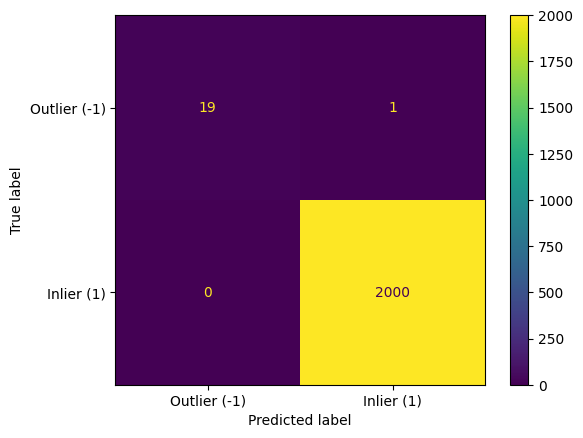

              precision    recall  f1-score   support

     Outlier       1.00      0.95      0.97        20
      Inlier       1.00      1.00      1.00      2000

    accuracy                           1.00      2020
   macro avg       1.00      0.97      0.99      2020
weighted avg       1.00      1.00      1.00      2020



In [35]:
# Evaluate
clf_report = evaluate_model(y_test, y_pred)

### Examples

In [38]:
# Ejemplos con el modelo EIF
def eif_label_and_score(model, Xdf, thr):
    score = float(model.predict(Xdf)[0])       # score isotree: alto = más anómalo
    is_outlier = bool(score >= thr)            # umbral por contaminación conocida
    return is_outlier, score

test_outlier = df[df["is_outlier"] == -1].sample(1).drop(columns=["is_outlier"])
test_inlier = df[df["is_outlier"] == 1].sample(1).drop(columns=["is_outlier"])
test_manual = pd.DataFrame([{
    "hearth_rate": 74.196677,
    "oxygen_saturation": 98.559586,
    "breathing_rate": 16.046316,
    "blood_pressure_systolic": 108.775277,
    "blood_presure_diastolic": 70.671704,
    "body_temperature": 36.648306,
}])

print("----- Predictions (EIF) -----")
print("Outlier: ", *eif_label_and_score(eif_clf, test_outlier, thr))
print("Inlier:  ", *eif_label_and_score(eif_clf, test_inlier,  thr))
print("Manual:  ", *eif_label_and_score(eif_clf, test_manual,  thr))


----- Predictions (EIF) -----
Outlier:  True 0.5802798792984709
Inlier:   False 0.3753907940011082
Manual:   False 0.3573772341631673


### Plot Decision Boundaries

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



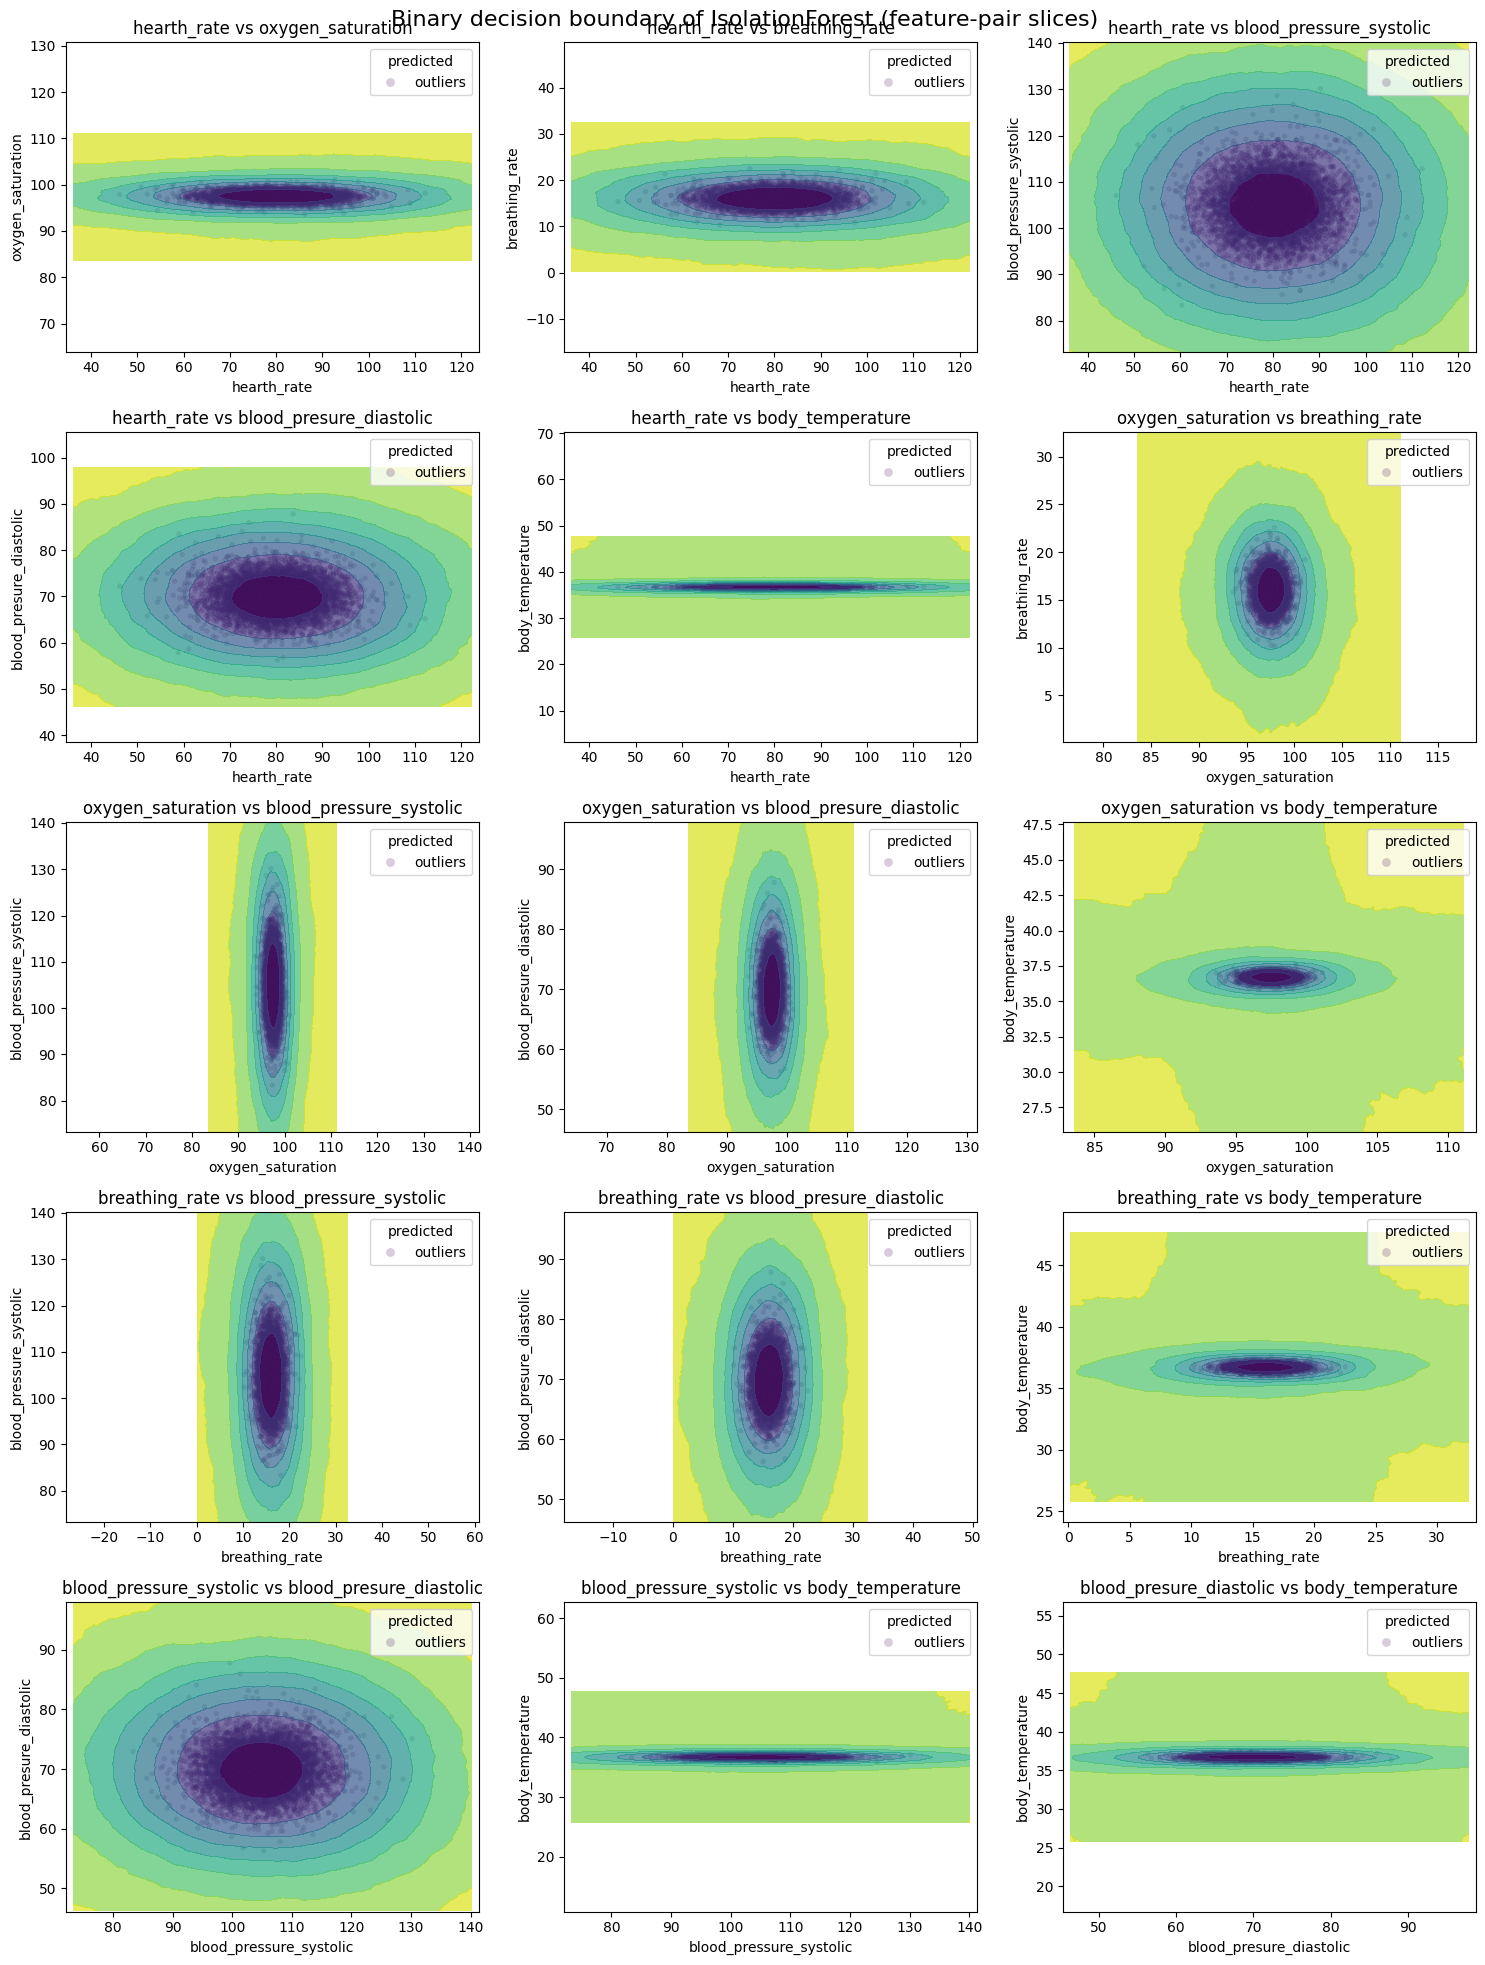

In [30]:
plot_iforest_boundaries_all_pairs(eif_clf, x_train)

### Save and load model

In [31]:
# Save model
from joblib import dump
artifact = {
    "model": eif_clf,                 # pipeline (scaler + EIF)
    "feature_names": x_train.columns.tolist(),
    "threshold": float(thr),
    "metadata": {
        "contamination": contamination,
        "library": "isotree",
    }
}
dump(artifact, "eif.joblib", compress=3)

['eif.joblib']

In [32]:
# Load model
from joblib import load
import pandas as pd
artifact = load("eif.joblib")
clf = artifact["model"]
thr = artifact["threshold"]
features = artifact["feature_names"]

Predicted is_outlier: False  · score: 0.3573772341631673


In [33]:
X_new = pd.DataFrame([{
    "hearth_rate": 74.196677,
    "oxygen_saturation": 98.559586,
    "breathing_rate": 16.046316,
    "blood_pressure_systolic": 108.775277,
    "blood_presure_diastolic": 70.671704,
    "body_temperature": 36.648306,
}], columns=features)

score = float(clf.predict(X_new)[0])      # higher => more anomalous
is_outlier = bool(score >= thr)
print("Predicted is_outlier:", is_outlier, " · score:", score)

Predicted is_outlier: False  · score: 0.3573772341631673


# Autoencoder (AE)
The Autoencoder is a feedforward neural network with a bottleneck in the middle, trained to reconstruct the given input at the net's output. The part up to the bottleneck (including it) is called the encoder, and aims to compress the input into fewer variables. Following the encoder is the decoder, whose task is to reconstruct the original input from the compressed values that the encoder produced. This training goal and the bottleneck forces the network to learn the underlying distribution of the dataset.

An autoencoder can be used as an anomaly detection model. It is trained on the inliers to learn the distribution. If an inlier is passed as an input, the model should be able to reconstruct something similar at the output, so the error metric (difference between reconstructed and actual value) should be low. Instead, if an outlier is passed as an input, the reconstructed value should differ from the actual one, and the error metric is high. By setting a threshold on the error metric, we can identify outliers from inliers



### Train and evaluate

In [36]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, callbacks

In [37]:
# --- Reproducibility (optional) ---
tf.random.set_seed(42)
np.random.seed(42)

In [59]:
# --- Fit scaler only on INLIERS (important for unsupervised AD) ---
scaler_ae = StandardScaler().fit(x_train_inliers.values)

Xtr_in = scaler_ae.transform(x_train_inliers.values)
Xva_in = scaler_ae.transform(x_test_inliers.values)  # validation on inliers
Xte_all = scaler_ae.transform(x_test.values)         # later used for evaluation

input_dim = Xtr_in.shape[1]

# --- Build a small, easy-to-train fully-connected autoencoder ---
def build_autoencoder(input_dim: int,
                      hidden=(16, 8),
                      bottleneck=4, # bottleneck should be smaller than the 6 dims of out dataset
                      dropout=0.0,
                      lr=1e-3) -> tf.keras.Model:
    """Simple symmetric autoencoder with MSE reconstruction loss."""
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(hidden[0], activation="relu")(inp)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden[1], activation="relu")(x)
    z = layers.Dense(bottleneck, activation="relu", name="bottleneck")(x)
    x = layers.Dense(hidden[1], activation="relu")(z)
    x = layers.Dense(hidden[0], activation="relu")(x)
    out = layers.Dense(input_dim, activation="linear")(x)

    model = models.Model(inputs=inp, outputs=out, name="autoencoder")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")
    return model

ae = build_autoencoder(input_dim, hidden=(16, 8), bottleneck=4, dropout=0.0, lr=1e-3)

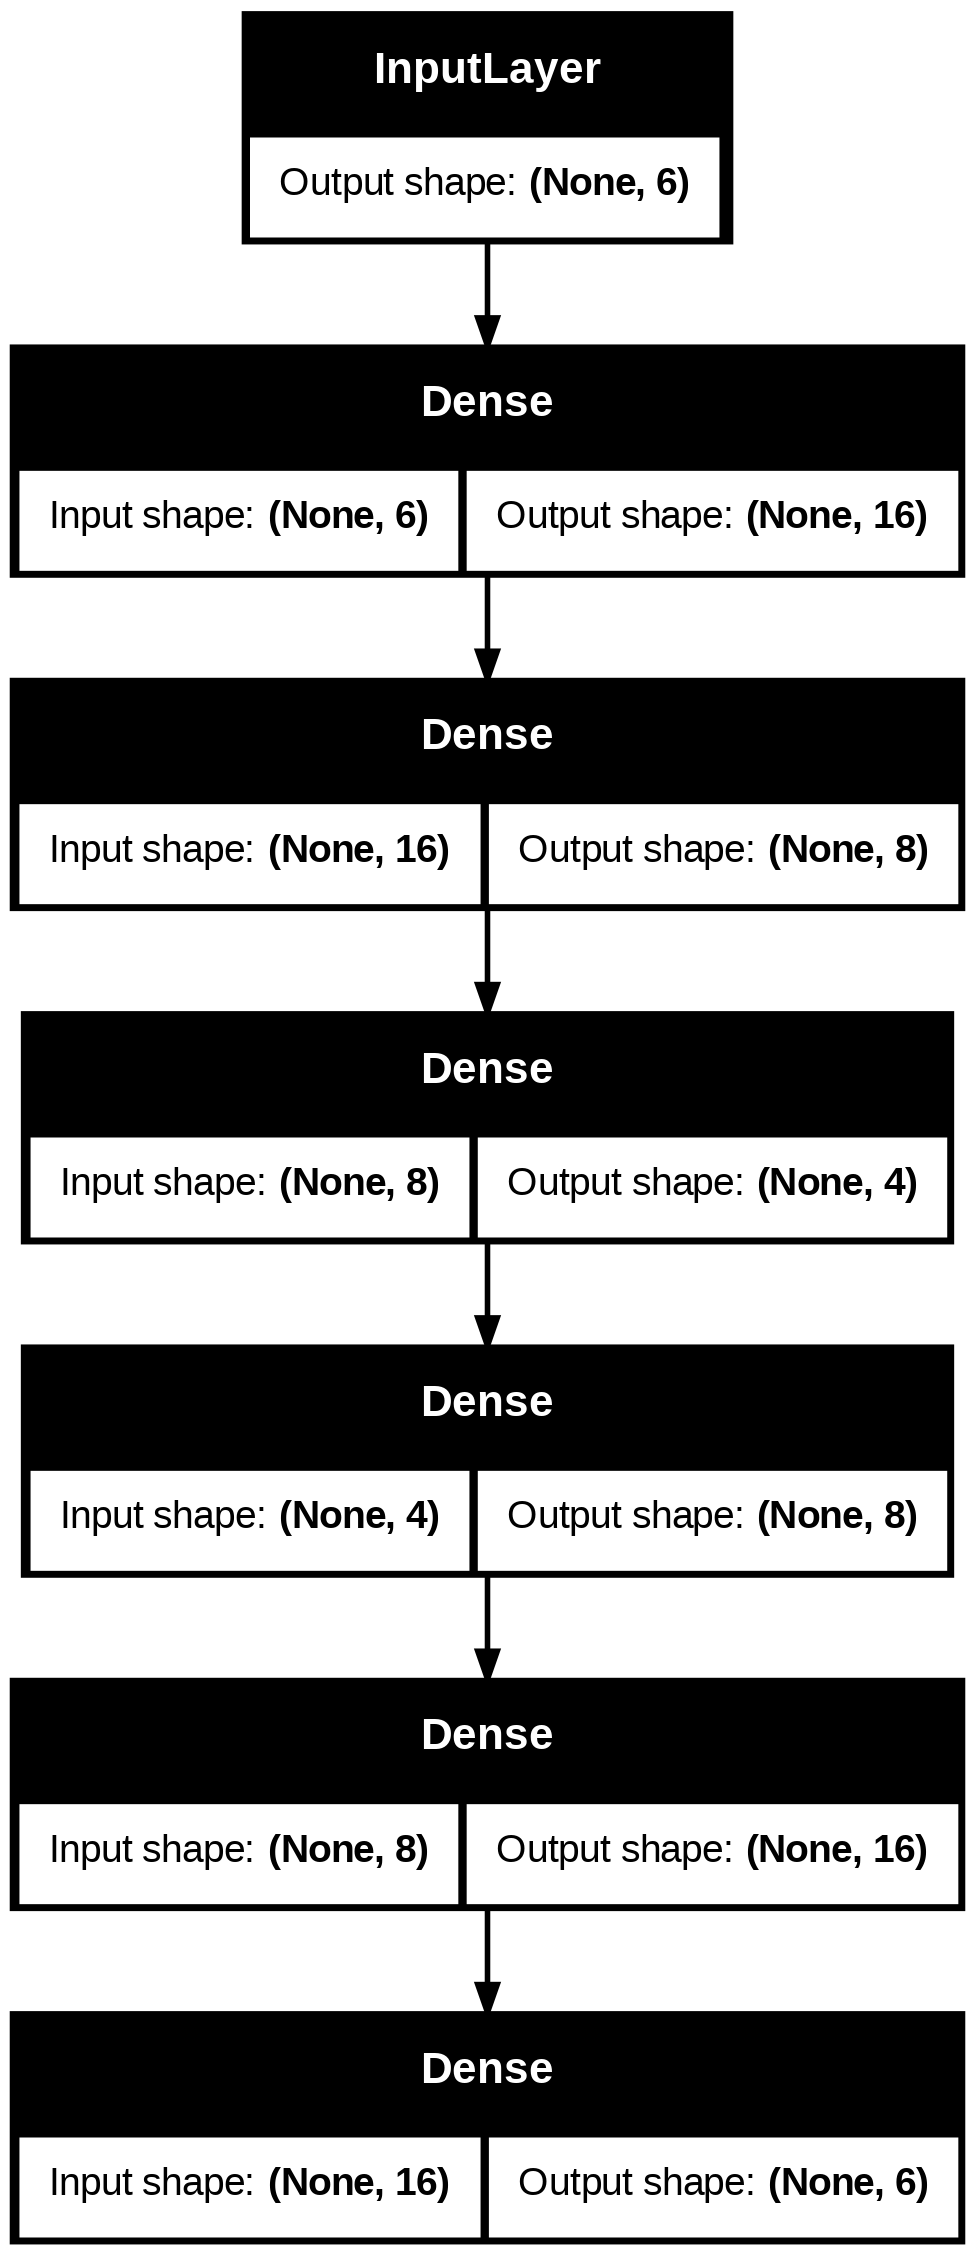

In [60]:
from tensorflow.keras.utils import plot_model

plot_model(ae, show_shapes=True, to_file='model_architecture.png')

In [61]:
# --- Train on inliers only (X -> X reconstruction) ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5
)

history = ae.fit(
    Xtr_in, Xtr_in,
    validation_data=(Xva_in, Xva_in),
    epochs=200,
    batch_size=256,
    verbose=0,
    callbacks=[early_stop, reduce_lr]
)

=== Autoencoder — Evaluation on test ===


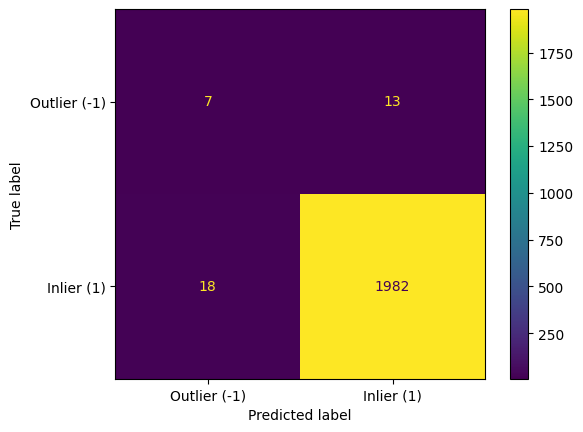

              precision    recall  f1-score   support

     Outlier       0.28      0.35      0.31        20
      Inlier       0.99      0.99      0.99      2000

    accuracy                           0.98      2020
   macro avg       0.64      0.67      0.65      2020
weighted avg       0.99      0.98      0.99      2020



In [62]:
# --- Reconstruction error utility ---
def reconstruction_error(model: tf.keras.Model, X: np.ndarray) -> np.ndarray:
    """Mean squared error per sample between input and reconstruction."""
    X_rec = model.predict(X, verbose=0)
    return np.mean((X - X_rec) ** 2, axis=1)

# --- Choose threshold using contamination on train-inliers ---
# Higher error => more anomalous. We flag the top "contamination" fraction.
err_train_in = reconstruction_error(ae, Xtr_in)
thr_ae = np.quantile(err_train_in, 1.0 - contamination)

# --- Predict on test and evaluate (map to {-1 (outlier), 1 (inlier)}) ---
err_test_all = reconstruction_error(ae, Xte_all)
y_pred_bool_ae = err_test_all >= thr_ae
y_pred_ae = np.where(y_pred_bool_ae, -1, 1)

print("=== Autoencoder — Evaluation on test ===")
_ = evaluate_model(y_test, y_pred_ae)

As we can see, the autoencoder does not perform so well. This is because our dataset contains 6 **independant** variables, and the bottleneck layer fails to capture the underlying distribution with less than 6 neurons, and if we use more than 6, then the bottleneck is no longer useful, because it learned a 1:1 reconstruction of the inputs (overfitting).

So in conclusion, **an autoencoder is not suitable** for our dataset.

### Examples

In [66]:
# --- Examples (mirrors your IF/EIF section) -----------------------------------
def ae_label_and_score(model: tf.keras.Model, scaler: StandardScaler,
                       Xdf: pd.DataFrame, thr: float):
    """Returns (is_outlier: bool, score: float) for a single-row DataFrame."""
    Xs = scaler.transform(Xdf.values)
    err = float(reconstruction_error(model, Xs)[0])  # higher = more anomalous
    return bool(err >= thr), err

# Prepare the same 3 examples you use elsewhere (one outlier, one inlier, one manual)
test_outlier = df[df["is_outlier"] == -1].sample(1).drop(columns=["is_outlier"])
test_inlier  = df[df["is_outlier"] ==  1].sample(1).drop(columns=["is_outlier"])
test_manual  = pd.DataFrame([{
    "hearth_rate": 74.196677,
    "oxygen_saturation": 98.559586,
    "breathing_rate": 16.046316,
    "blood_pressure_systolic": 108.775277,
    "blood_presure_diastolic": 70.671704,
    "body_temperature": 36.648306,
}])

print("----- Predictions (Autoencoder) -----")
print("Outlier: ", *ae_label_and_score(ae, scaler_ae, test_outlier, thr_ae))
print("Inlier:  ", *ae_label_and_score(ae, scaler_ae, test_inlier,  thr_ae))
print("Manual:  ", *ae_label_and_score(ae, scaler_ae, test_manual,  thr_ae))

----- Predictions (Autoencoder) -----
Outlier:  True 1.2625360533895436
Inlier:   False 0.2167187351478088
Manual:   False 0.0569897864868548


### Save and load model

In [67]:
# --- Save model + artifacts ----------------------------------------------------
# We save the Keras model separately and keep scaler + threshold in a joblib artifact.
from joblib import dump, load

os.makedirs("ae_artifacts", exist_ok=True)
ae_path = os.path.join("ae_artifacts", "autoencoder.keras")
ae.save(ae_path)  # native Keras format

ae_meta = {
    "feature_names": x_train.columns.tolist(),
    "threshold": float(thr_ae),
    "contamination": float(contamination),
    "scaler": scaler_ae,                # fitted StandardScaler
    "model_path": ae_path
}
dump(ae_meta, os.path.join("ae_artifacts", "autoencoder_meta.joblib"), compress=3)
print("Saved:", ae_path, "and ae_artifacts/autoencoder_meta.joblib")

Saved: ae_artifacts/autoencoder.keras and ae_artifacts/autoencoder_meta.joblib


In [68]:
# --- Load model + artifacts and run a one-sample inference --------------------
from joblib import load
from tensorflow.keras.models import load_model

meta = load(os.path.join("ae_artifacts", "autoencoder_meta.joblib"))
ae_loaded = load_model(meta["model_path"])
scaler_loaded = meta["scaler"]
thr_loaded = meta["threshold"]
features = meta["feature_names"]

# One-sample payload (same as your previous examples)
X_new = pd.DataFrame([{
    "hearth_rate": 74.196677,
    "oxygen_saturation": 98.559586,
    "breathing_rate": 16.046316,
    "blood_pressure_systolic": 108.775277,
    "blood_presure_diastolic": 70.671704,
    "body_temperature": 36.648306,
}], columns=features)  # enforce feature order

err = float(reconstruction_error(ae_loaded, scaler_loaded.transform(X_new.values))[0])
is_outlier = bool(err >= thr_loaded)
print("Predicted is_outlier:", is_outlier, " · score (reconstruction MSE):", err)

Predicted is_outlier: False  · score (reconstruction MSE): 0.0569897864868548


# Conclusion: use EIF
Up to this point, we trained three models:
*   **Isolation Forest (IF):** it has the limitation of axis-parallel splitting, so it is discarded
*   **Extended Isolation Forest (EIF):** by using hyperplanes with more than two variables instead of splitting on a random axis, it corrects the isoforest limitation
*   **Autoencoder (AE):** not suitable for our dataset, as it fails to reconstruct the signal with a bottleneck layer with less than 6 neurons (we have 6 independant variables in the dataset)

The algorithm to be used in the project will be **Extended Isolation Forest**